### 1. Download Dataset

In [17]:
import re
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)

In [19]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shailshree\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\shailshree\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### 2. Load Dataset

In [3]:
PATH = "train.csv"  # change if needed
df = pd.read_csv(PATH)

# Set column names here if your file differs
TEXT_COL = "tweet"
LABEL_COL = "label"

# Basic sanity checks
if TEXT_COL not in df.columns or LABEL_COL not in df.columns:
    raise ValueError(
        f"Expected columns '{TEXT_COL}' and '{LABEL_COL}'. "
        f"Found: {list(df.columns)}. Update TEXT_COL/LABEL_COL accordingly."
    )

In [4]:
df = df[[TEXT_COL, LABEL_COL]].dropna()
df[LABEL_COL] = df[LABEL_COL].astype(int)

In [5]:
df.head()

,tweet,label
0,@user when a father is dysfunctional and is s...,0
1,@user @user thanks for #lyft credit i can't us...,0
2,bihday your majesty,0
3,#model i love u take with u all the time in ...,0
4,factsguide: society now #motivation,0


### 2) Show class distribution (imbalance check)

In [6]:
class_counts = df[LABEL_COL].value_counts().sort_index()
class_percent = df[LABEL_COL].value_counts(normalize=True).sort_index() * 100

print("Class Counts:\n", class_counts)
print("\nClass Percentages (%):\n", class_percent.round(2))

Class Counts:
 label
0    29720
1     2242
Name: count, dtype: int64

Class Percentages (%):
 label
0    92.99
1     7.01
Name: proportion, dtype: float64


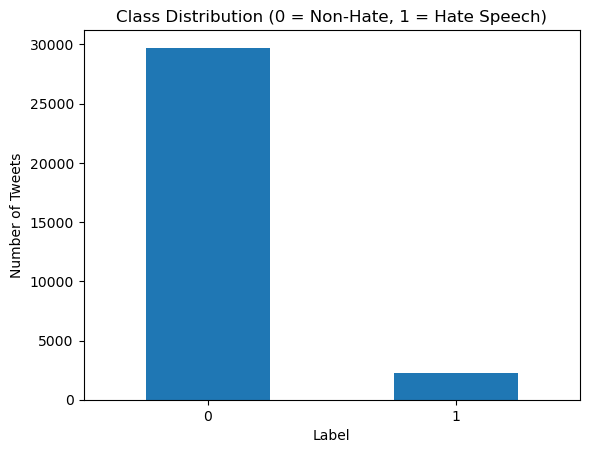

In [7]:
# Plot distribution
plt.figure()
class_counts.plot(kind="bar")
plt.title("Class Distribution (0 = Non-Hate, 1 = Hate Speech)")
plt.xlabel("Label")
plt.ylabel("Number of Tweets")
plt.xticks(rotation=0)
plt.show()

### 3) Explotary Data Analysis (EDA)

### 4) Select Features and Labels

In [13]:
# text and label columns
X = df['tweet']      # input text column
y = df['label']     # target label column

### 5) Train–Test Split (Stratified)

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

### 6) Text preprocessing

In [22]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
      # Remove URLs
    text = re.sub(r"http\S+|www\.\S+", " ", text)

    # Remove user mentions (@user is present in this dataset)
    text = re.sub(r"@\w+", " ", text)

    # Remove hashtags symbol (keep word)
    text = re.sub(r"#", " ", text)

    # Keep only letters and spaces (removes numbers/punct/emojis)
    text = re.sub(r"[^a-z\s]", " ", text)

    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()
    
    tokens = text.split()
    tokens = [
        lemmatizer.lemmatize(word)
        for word in tokens
        if word not in stop_words
    ]
    return ' '.join(tokens)

X_train = X_train.apply(preprocess_text)
X_test  = X_test.apply(preprocess_text)

### 7) Feature Extraction (TF-IDF)

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2)
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)


### 8) Model Training

#### 8.1) Naive Byes

In [24]:
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

MultinomialNB()

#### 8.2) Logistic Regression (Class Imbalance Aware)

In [25]:
lr_model = LogisticRegression(
    class_weight='balanced',
    max_iter=1000
)

lr_model.fit(X_train_tfidf, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

### 9) Model Evaluation

In [27]:
nb_pred = nb_model.predict(X_test_tfidf)
lr_pred = lr_model.predict(X_test_tfidf)

print("Naive Bayes Report:\n")
print(classification_report(y_test, nb_pred))


Naive Bayes Report:

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      5945
           1       0.96      0.30      0.45       448

    accuracy                           0.95      6393
   macro avg       0.95      0.65      0.71      6393
weighted avg       0.95      0.95      0.94      6393



In [28]:
print("Logistic Regression Report:\n")
print(classification_report(y_test, lr_pred))

Logistic Regression Report:

              precision    recall  f1-score   support

           0       0.98      0.94      0.96      5945
           1       0.50      0.77      0.61       448

    accuracy                           0.93      6393
   macro avg       0.74      0.86      0.78      6393
weighted avg       0.95      0.93      0.94      6393



In [29]:
print("Confusion Matrix (Logistic Regression):\n")
print(confusion_matrix(y_test, lr_pred))


Confusion Matrix (Logistic Regression):

[[5597  348]
 [ 101  347]]
